In [ ]:
! pip install transformers datasets evaluate
! pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 3.2 MB/s eta 0:00:00


In [ ]:
# Importing the SQuAD Dataset
from datasets import load_dataset

# Importing smaller version of SQuAD for tuning training
data = load_dataset("squad", split="train[70000:]")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [ ]:
data = data.train_test_split(test_size=0.2)
data

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, TrainingArguments, Trainer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForQuestionAnswering.from_pretrained("distilbert-base-uncased")
model.to("cuda")

KeyboardInterrupt: ignored

In [ ]:
def preprocess_data(data):
  questions = [q.strip() for q in data["question"]]
  input = tokenizer(questions,
                    data["context"],
                    max_length=400,
                    truncation="only_second",
                    return_offsets_mapping=True,
                    padding="max_length") # max_length was 384

  offset_mapping = input.pop("offset_mapping")
  answers = data["answers"]
  start_positions = []
  end_positions = []

  for i, offset in enumerate(offset_mapping):
        answer = answers[i]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = input.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1

        context_end = idx - 1
        # If the answer is not fully inside the context, label it (0, 0)
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1

            start_positions.append(idx - 1)
            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1

            end_positions.append(idx + 1)
  input["start_positions"] = start_positions
  input["end_positions"] = end_positions

  return input

In [ ]:
tokenized_data = data.map(preprocess_data, batched=True, remove_columns=data["train"].column_names)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

In [ ]:
from evaluate import load

metrics = load("squad")

In [ ]:
training_args = TrainingArguments(
    output_dir="model",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["test"],
    tokenizer=tokenizer,
    data_collator=data_collator
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,3.468254
2,No log,3.195721


TrainOutput(global_step=250, training_loss=3.740065185546875, metrics={'train_runtime': 155.1178, 'train_samples_per_second': 25.787, 'train_steps_per_second': 1.612, 'total_flos': 408290937600000.0, 'train_loss': 3.740065185546875, 'epoch': 2.0})

In [ ]:
model.save_pretrained("./sample_model")
tokenizer.save_pretrained("./sample_model")

In [ ]:
from transformers import pipeline

In [ ]:
! pip install peft

In [ ]:
from peft import PeftModelForQuestionAnswering, get_peft_config
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, TrainingArguments, Trainer


config = {
    "peft_type": "LORA",
    "task_type": "QUESTION_ANS",
    "inference_mode": False,
    "r": 16,
    "target_modules": ["query", "value"],
    "lora_alpha": 32,
    "lora_dropout": 0.05,
    "fan_in_fan_out": False,
    "bias": "none",
}

peft_config = get_peft_config(config)

ModuleNotFoundError: ignored

In [ ]:
test_model = AutoModelForQuestionAnswering.from_pretrained("bert-base-cased")

peft_model = PeftModelForQuestionAnswering(test_model, peft_config)

peft_model.print_trainable_parameters()

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 591,362 || all params: 108,312,580 || trainable%: 0.5459772078183347


In [ ]:
peft_training_args = TrainingArguments(
    output_dir="peft_model2",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
)


peft_trainer_2 = Trainer(
    model=model,
    args=peft_training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    #compute_metrics=metrics
)

peft_trainer_2.train()

Epoch,Training Loss,Validation Loss
1,No log,2.191337
2,No log,2.057123


TrainOutput(global_step=250, training_loss=2.292124755859375, metrics={'train_runtime': 156.8363, 'train_samples_per_second': 25.504, 'train_steps_per_second': 1.594, 'total_flos': 408290937600000.0, 'train_loss': 2.292124755859375, 'epoch': 2.0})

In [ ]:
peft_training_args = TrainingArguments(
    output_dir="peft_model",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
)


peft_trainer = Trainer(
    model=peft_model,
    args=peft_training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    #compute_metrics=metrics
)

NameError: ignored

In [ ]:
peft_model.to("cuda")
peft_trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,5.333298
2,No log,5.105617


TrainOutput(global_step=250, training_loss=5.39843505859375, metrics={'train_runtime': 249.1231, 'train_samples_per_second': 16.056, 'train_steps_per_second': 1.004, 'total_flos': 822229440000000.0, 'train_loss': 5.39843505859375, 'epoch': 2.0})

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("/content/CustomNPC_dataset.csv")
df[0:10]

,Context,Question,Answer_Text,Answer_Start_Index,Title
0,Dragon Quest V begins with a brief scene of th...,Who can the Hero marry?,"Nera, but it is also possible for him to marry...",1247,Dragon Quest V
1,Dragon Quest V begins with a brief scene of th...,What is the Hero's homeland?,Gotha,1373,Dragon Quest V
2,Dragon Quest V begins with a brief scene of th...,What did the Hero and Bianca obtain from the U...,a mysterious Golden Orb,288,Dragon Quest V
3,Dragon Quest V begins with a brief scene of th...,Who is the daughter of Rodrigo Briscoletti?,Nera,997,Dragon Quest V
4,Dragon Quest V begins with a brief scene of th...,Who killed Pankraz?,Ladja,592,Dragon Quest V
5,Dragon Quest V begins with a brief scene of th...,How does the Hero avenge Pankraz?,killing Ladja,1873,Dragon Quest V
6,Dragon Quest V begins with a brief scene of th...,Who does the Hero retrieve the golden orb from...,his child self,2065,Dragon Quest V
7,"Skyrim, also known as the Old Kingdom, Throat ...",What is Skyrim also known as?,"Old Kingdom, Throat of the World, the Fatherla...",26,Skyrim
8,"Skyrim, also known as the Old Kingdom, Throat ...",What is Skyrim?,a vast region set in the northern part of Tamriel,91,Skyrim
9,"Skyrim, also known as the Old Kingdom, Throat ...",Where is the home of the Nords?,Skyrim,0,Skyrim


In [ ]:
# answers text and answer_start_index into answers
answers = list()
ans_text = df['Answer_Text']
ans_sidx = df['Answer_Start_Index']
for i in range(len(ans_text)):
  answers.append({
      'text':[ans_text[i]],
      'answer_start':[ans_sidx[i]],
  })
print(answers[:10])

[{'text': ['Nera, but it is also possible for him to marry Bianca or Debora'], 'answer_start': [1247]}, {'text': ['Gotha'], 'answer_start': [1373]}, {'text': ['a mysterious Golden Orb'], 'answer_start': [288]}, {'text': ['Nera'], 'answer_start': [997]}, {'text': ['Ladja'], 'answer_start': [592]}, {'text': ['killing Ladja'], 'answer_start': [1873]}, {'text': ['his child self'], 'answer_start': [2065]}, {'text': ['Old Kingdom, Throat of the World, the Fatherland, or Keizaal'], 'answer_start': [26]}, {'text': ['a vast region set in the northern part of Tamriel'], 'answer_start': [91]}, {'text': ['Skyrim'], 'answer_start': [0]}]


In [ ]:
df['answers'] = answers
df[:5]

,Context,Question,Answer_Text,Answer_Start_Index,Title,answers
0,Dragon Quest V begins with a brief scene of th...,Who can the Hero marry?,"Nera, but it is also possible for him to marry...",1247,Dragon Quest V,"{'text': ['Nera, but it is also possible for h..."
1,Dragon Quest V begins with a brief scene of th...,What is the Hero's homeland?,Gotha,1373,Dragon Quest V,"{'text': ['Gotha'], 'answer_start': [1373]}"
2,Dragon Quest V begins with a brief scene of th...,What did the Hero and Bianca obtain from the U...,a mysterious Golden Orb,288,Dragon Quest V,"{'text': ['a mysterious Golden Orb'], 'answer_..."
3,Dragon Quest V begins with a brief scene of th...,Who is the daughter of Rodrigo Briscoletti?,Nera,997,Dragon Quest V,"{'text': ['Nera'], 'answer_start': [997]}"
4,Dragon Quest V begins with a brief scene of th...,Who killed Pankraz?,Ladja,592,Dragon Quest V,"{'text': ['Ladja'], 'answer_start': [592]}"


In [ ]:
df = df.drop(['Answer_Text', 'Answer_Start_Index'], axis=1)
df[:5]

,Context,Question,Title,answers
0,Dragon Quest V begins with a brief scene of th...,Who can the Hero marry?,Dragon Quest V,"{'text': ['Nera, but it is also possible for h..."
1,Dragon Quest V begins with a brief scene of th...,What is the Hero's homeland?,Dragon Quest V,"{'text': ['Gotha'], 'answer_start': [1373]}"
2,Dragon Quest V begins with a brief scene of th...,What did the Hero and Bianca obtain from the U...,Dragon Quest V,"{'text': ['a mysterious Golden Orb'], 'answer_..."
3,Dragon Quest V begins with a brief scene of th...,Who is the daughter of Rodrigo Briscoletti?,Dragon Quest V,"{'text': ['Nera'], 'answer_start': [997]}"
4,Dragon Quest V begins with a brief scene of th...,Who killed Pankraz?,Dragon Quest V,"{'text': ['Ladja'], 'answer_start': [592]}"


In [ ]:
ids = list()
for i in range(len(df['Context'])):
  new_id = ["0"] * len(df['Context'])
  new_id[i] = "1"
  new_id = "".join(new_id)
  ids.append(new_id)
df['id'] = ids
df[:5]

,Context,Question,Title,answers,id
0,Dragon Quest V begins with a brief scene of th...,Who can the Hero marry?,Dragon Quest V,"{'text': ['Nera, but it is also possible for h...",1000000000000000000000000000000000000000000000...
1,Dragon Quest V begins with a brief scene of th...,What is the Hero's homeland?,Dragon Quest V,"{'text': ['Gotha'], 'answer_start': [1373]}",0100000000000000000000000000000000000000000000...
2,Dragon Quest V begins with a brief scene of th...,What did the Hero and Bianca obtain from the U...,Dragon Quest V,"{'text': ['a mysterious Golden Orb'], 'answer_...",0010000000000000000000000000000000000000000000...
3,Dragon Quest V begins with a brief scene of th...,Who is the daughter of Rodrigo Briscoletti?,Dragon Quest V,"{'text': ['Nera'], 'answer_start': [997]}",0001000000000000000000000000000000000000000000...
4,Dragon Quest V begins with a brief scene of th...,Who killed Pankraz?,Dragon Quest V,"{'text': ['Ladja'], 'answer_start': [592]}",0000100000000000000000000000000000000000000000...


In [ ]:
from datasets import Dataset, DatasetDict

df = df.sample(frac=1)
#df = df.reset_index()

final_df = pd.DataFrame({
    'id':df['id'],
    'title':df['Title'],
    'context':df['Context'],
    'question':df['Question'],
    'answers':df['answers']
})

#final_df = final_df.sample(frac=1)

#final_df = final_df.drop(['__index_level_0__'], axis=0)

train = Dataset.from_pandas(final_df[:79])
test = Dataset.from_pandas(final_df[79:])

test_df = final_df[79:]
test_df = test_df.reset_index()

ds = DatasetDict()
ds['train'] = train
ds['test'] = test

#ds = ds.remove_columns(["__index_level_0__"])

print(ds)

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers', '__index_level_0__'],
        num_rows: 79
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers', '__index_level_0__'],
        num_rows: 20
    })
})


In [ ]:
from peft import PeftModelForQuestionAnswering, get_peft_config
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, TrainingArguments, Trainer

config = {
    "peft_type": "LORA",
    "task_type": "QUESTION_ANS",
    "inference_mode": False,
    "r": 16,
    "target_modules": ["query", "value"],
    "lora_alpha": 32,
    "lora_dropout": 0.05,
    "fan_in_fan_out": False,
    "bias": "none",
}

peft_config = get_peft_config(config)
test_model = AutoModelForQuestionAnswering.from_pretrained("bert-base-cased")
peft_model = PeftModelForQuestionAnswering(test_model, peft_config)
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
peft_model.print_trainable_parameters()

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 591,362 || all params: 108,312,580 || trainable%: 0.5459772078183347


In [ ]:
tokenized_ds = ds.map(preprocess_data, batched=True, remove_columns=ds["train"].column_names)

Map:   0%|          | 0/79 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

In [ ]:
peft_training_args = TrainingArguments(
    output_dir="peft_model",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
)

peft_trainer = Trainer(
    model=peft_model,
    args=peft_training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

In [ ]:
peft_trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,5.984941
2,No log,5.979847
3,No log,5.975202
4,No log,5.971210
5,No log,5.967796
6,No log,5.964900
7,No log,5.962594
8,No log,5.960938
9,No log,5.959914
10,No log,5.959530


TrainOutput(global_step=50, training_loss=5.97571044921875, metrics={'train_runtime': 47.1134, 'train_samples_per_second': 16.768, 'train_steps_per_second': 1.061, 'total_flos': 162390314400000.0, 'train_loss': 5.97571044921875, 'epoch': 10.0})

In [ ]:
peft_model.cpu()
qa_pipe2 = pipeline(
    'question-answering',
    model = peft_model,
    tokenizer = tokenizer
)

The model 'PeftModelForQuestionAnswering' is not supported for question-answering. Supported models are ['AlbertForQuestionAnswering', 'BartForQuestionAnswering', 'BertForQuestionAnswering', 'BigBirdForQuestionAnswering', 'BigBirdPegasusForQuestionAnswering', 'BloomForQuestionAnswering', 'CamembertForQuestionAnswering', 'CanineForQuestionAnswering', 'ConvBertForQuestionAnswering', 'Data2VecTextForQuestionAnswering', 'DebertaForQuestionAnswering', 'DebertaV2ForQuestionAnswering', 'DistilBertForQuestionAnswering', 'ElectraForQuestionAnswering', 'ErnieForQuestionAnswering', 'ErnieMForQuestionAnswering', 'FalconForQuestionAnswering', 'FlaubertForQuestionAnsweringSimple', 'FNetForQuestionAnswering', 'FunnelForQuestionAnswering', 'GPT2ForQuestionAnswering', 'GPTNeoForQuestionAnswering', 'GPTNeoXForQuestionAnswering', 'GPTJForQuestionAnswering', 'IBertForQuestionAnswering', 'LayoutLMv2ForQuestionAnswering', 'LayoutLMv3ForQuestionAnswering', 'LEDForQuestionAnswering', 'LiltForQuestionAnswering

In [ ]:
def check_model_performance(model_pipe, test):
  preds = list()
  refs = list()

  for i in range(1, len(test)):
  #for i in range(1):
    pred = model_pipe(context=test['context'][i], question=test['question'][i])


    clean_pred = {
        'prediction_text':pred['answer'],
        'id':test['id'][i]
    }

    ref = {
        'answers': test['answers'][i],
        'id':test['id'][i]
    }

    preds.append(clean_pred)
    refs.append(ref)

  return metrics.compute(predictions=preds, references=refs)

In [ ]:
print(check_model_performance(qa_pipe2, final_df))

{'exact_match': 0.0, 'f1': 7.574553833583763}


In [ ]:
test_df['context']

0     Dragon Quest XI is set in the world of Erdrea ...
1     Taking place in modern-day Tokyo, Persona 5 fo...
2     Twin’s Peak is a large city located at the pea...
3     Northwick is a small village in the valley tha...
4     Dragon Quest XI is set in the world of Erdrea ...
5     Dragon Quest XI is set in the world of Erdrea ...
6     Northwick is a small village in the valley tha...
7     Twin’s Peak is a large city located at the pea...
8     Twin’s Peak is a large city located at the pea...
9     Dragon Quest V begins with a brief scene of th...
10    Taking place in modern-day Tokyo, Persona 5 fo...
11    Dragon Quest XI is set in the world of Erdrea ...
12    Dragon Quest V begins with a brief scene of th...
13    Skyrim, also known as the Old Kingdom, Throat ...
14    Dragon Quest V begins with a brief scene of th...
15    Twin’s Peak is a large city located at the pea...
16    Twin’s Peak is a large city located at the pea...
17    Dragon Quest V begins with a brief scene o

In [ ]:
model_names = ['brt_model/','dstbrt_model/','rbrta_model/']
part_path = '/content/drive/MyDrive/NLP/'

for mn in model_names:
  path = part_path + mn

  print("Model: {}...".format(mn))

  model = AutoModelForQuestionAnswering.from_pretrained(path)
  #tokenizer = AutoTokenizer.from_pretrained(path)

  if mn == 'brt_model/':
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
  elif mn == 'dstbrt_model/':
    tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
  elif mn == 'rbrta_model/':
    tokenizer = AutoTokenizer.from_pretrained('roberta-base')

  qa_pipe = pipeline(
    'question-answering',
    model = model,
    tokenizer = tokenizer
  )

  print("Performance: {}".format(check_model_performance(qa_pipe, test_df)))
  print("Example Performance - Question: {}, Prediction: {}, Answer: {}".format(test_df['question'][0], qa_pipe(context=test_df['context'][0], question=test_df['question'][0]), test_df['answers'][0]))

Model: brt_model/...
Performance: {'exact_match': 57.89473684210526, 'f1': 80.95537757437071}
Example Performance - Question: Why is Veronica trapped in a child's body?, Prediction: {'score': 0.8418619632720947, 'start': 926, 'end': 931, 'answer': 'curse'}, Answer: {'text': ['curse'], 'answer_start': [926]}
Model: dstbrt_model/...


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Performance: {'exact_match': 63.1578947368421, 'f1': 83.12443658553498}
Example Performance - Question: Why is Veronica trapped in a child's body?, Prediction: {'score': 0.9971417784690857, 'start': 924, 'end': 931, 'answer': 'a curse'}, Answer: {'text': ['curse'], 'answer_start': [926]}
Model: rbrta_model/...


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Performance: {'exact_match': 68.42105263157895, 'f1': 89.72730739893211}
Example Performance - Question: Why is Veronica trapped in a child's body?, Prediction: {'score': 0.9999988079071045, 'start': 924, 'end': 931, 'answer': 'a curse'}, Answer: {'text': ['curse'], 'answer_start': [926]}


In [ ]:
from peft import PeftModelForQuestionAnswering, get_peft_config
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, TrainingArguments, Trainer
from transformers import DefaultDataCollator
from transformers import pipeline

data_collator = DefaultDataCollator()
# Automated LoRA Training
model_names = ['brt_model/','rbrta_model/']
part_path = '/content/drive/MyDrive/NLP/'

config = {
    "peft_type": "LORA",
    "task_type": "QUESTION_ANS",
    "inference_mode": False,
    "r": 16,
    "target_modules": ["query", "value"],
    "lora_alpha": 32,
    "lora_dropout": 0.05,
    "fan_in_fan_out": False,
    "bias": "none",
}

peft_config = get_peft_config(config)

for mn in model_names:
  path = part_path + mn

  print("Model: {}...".format(mn))

  model = AutoModelForQuestionAnswering.from_pretrained(path)
  #tokenizer = AutoTokenizer.from_pretrained(path)
  peft_model = PeftModelForQuestionAnswering(model, peft_config)
  peft_model.print_trainable_parameters()

  #peft_model.to("cuda")

  if mn == 'brt_model/':
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
  elif mn == 'dstbrt_model/':
    tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
  elif mn == 'rbrta_model/':
    tokenizer = AutoTokenizer.from_pretrained('roberta-base')

  peft_training_args = TrainingArguments(
      output_dir="./lora_" + mn,
      evaluation_strategy="epoch",
      learning_rate=2e-5,
      per_device_train_batch_size=16,
      per_device_eval_batch_size=16,
      num_train_epochs=20,
      weight_decay=0.01,
  )

  peft_trainer = Trainer(
      model=peft_model,
      args=peft_training_args,
      train_dataset=tokenized_ds["train"],
      eval_dataset=tokenized_ds["test"],
      tokenizer=tokenizer,
      data_collator=data_collator,
  )

  #peft_model.to("cuda")
  peft_trainer.train()

  peft_model.cpu()

  qa_pipe = pipeline(
    'question-answering',
    model = peft_model,
    tokenizer = tokenizer
  )

  print("Performance: {}".format(check_model_performance(qa_pipe, test_df)))
  print("Example Performance - Question: {}, Prediction: {}, Answer: {}".format(test_df['question'][0], qa_pipe(context=test_df['context'][0], question=test_df['question'][0]), test_df['answers'][0]))

Model: brt_model/...
trainable params: 591,362 || all params: 109,484,548 || trainable%: 0.5401328413942029


Epoch,Training Loss,Validation Loss
1,No log,10.088773
2,No log,9.760792
3,No log,9.424161
4,No log,9.080415
5,No log,8.735329
6,No log,8.386072
7,No log,8.040803
8,No log,7.700400
9,No log,7.378400
10,No log,7.082500


The model 'PeftModelForQuestionAnswering' is not supported for question-answering. Supported models are ['AlbertForQuestionAnswering', 'BartForQuestionAnswering', 'BertForQuestionAnswering', 'BigBirdForQuestionAnswering', 'BigBirdPegasusForQuestionAnswering', 'BloomForQuestionAnswering', 'CamembertForQuestionAnswering', 'CanineForQuestionAnswering', 'ConvBertForQuestionAnswering', 'Data2VecTextForQuestionAnswering', 'DebertaForQuestionAnswering', 'DebertaV2ForQuestionAnswering', 'DistilBertForQuestionAnswering', 'ElectraForQuestionAnswering', 'ErnieForQuestionAnswering', 'ErnieMForQuestionAnswering', 'FalconForQuestionAnswering', 'FlaubertForQuestionAnsweringSimple', 'FNetForQuestionAnswering', 'FunnelForQuestionAnswering', 'GPT2ForQuestionAnswering', 'GPTNeoForQuestionAnswering', 'GPTNeoXForQuestionAnswering', 'GPTJForQuestionAnswering', 'IBertForQuestionAnswering', 'LayoutLMv2ForQuestionAnswering', 'LayoutLMv3ForQuestionAnswering', 'LEDForQuestionAnswering', 'LiltForQuestionAnswering

Performance: {'exact_match': 21.05263157894737, 'f1': 32.748538011695906}
Example Performance - Question: Where does Rodrigo Briscoletti and his daughter live?, Prediction: {'score': 0.9872557520866394, 'start': 918, 'end': 931, 'answer': 'Mostroferrato'}, Answer: {'text': ['Mostroferrato'], 'answer_start': [918]}
Model: rbrta_model/...
trainable params: 591,362 || all params: 124,647,940 || trainable%: 0.47442581080762347


Epoch,Training Loss,Validation Loss
1,No log,15.806211
2,No log,13.992575
3,No log,11.716604
4,No log,9.934031
5,No log,8.743620
6,No log,8.017769
7,No log,7.556749
8,No log,7.190852
9,No log,6.885422
10,No log,6.542966


The model 'PeftModelForQuestionAnswering' is not supported for question-answering. Supported models are ['AlbertForQuestionAnswering', 'BartForQuestionAnswering', 'BertForQuestionAnswering', 'BigBirdForQuestionAnswering', 'BigBirdPegasusForQuestionAnswering', 'BloomForQuestionAnswering', 'CamembertForQuestionAnswering', 'CanineForQuestionAnswering', 'ConvBertForQuestionAnswering', 'Data2VecTextForQuestionAnswering', 'DebertaForQuestionAnswering', 'DebertaV2ForQuestionAnswering', 'DistilBertForQuestionAnswering', 'ElectraForQuestionAnswering', 'ErnieForQuestionAnswering', 'ErnieMForQuestionAnswering', 'FalconForQuestionAnswering', 'FlaubertForQuestionAnsweringSimple', 'FNetForQuestionAnswering', 'FunnelForQuestionAnswering', 'GPT2ForQuestionAnswering', 'GPTNeoForQuestionAnswering', 'GPTNeoXForQuestionAnswering', 'GPTJForQuestionAnswering', 'IBertForQuestionAnswering', 'LayoutLMv2ForQuestionAnswering', 'LayoutLMv3ForQuestionAnswering', 'LEDForQuestionAnswering', 'LiltForQuestionAnswering

Performance: {'exact_match': 73.6842105263158, 'f1': 87.87417261101473}
Example Performance - Question: Where does Rodrigo Briscoletti and his daughter live?, Prediction: {'score': 1.0, 'start': 918, 'end': 931, 'answer': 'Mostroferrato'}, Answer: {'text': ['Mostroferrato'], 'answer_start': [918]}


In [ ]:
test_set = data['test'][:200]

test_set['id'][0]

'5733ec05d058e614000b65e3'

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
from transformers import pipeline

model_names = ['brt_model/','dstbrt_model/','rbrta_model/']
part_path = '/content/drive/MyDrive/NLP/'
test_set = data['test'][:2000]

for mn in model_names:
  path = part_path + mn

  print("Model: {}...".format(mn))

  model = AutoModelForQuestionAnswering.from_pretrained(path)
  #tokenizer = AutoTokenizer.from_pretrained(path)

  if mn == 'brt_model/':
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
  elif mn == 'dstbrt_model/':
    tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
  elif mn == 'rbrta_model/':
    tokenizer = AutoTokenizer.from_pretrained('roberta-base')

  qa_pipe = pipeline(
    'question-answering',
    model = model,
    tokenizer = tokenizer
  )

  print("Performance: {}".format(check_model_performance(qa_pipe, test_set)))
  print("Example Performance - Question: {}, Prediction: {}, Answer: {}".format(test_set['question'][0], qa_pipe(context=test_set['context'][0], question=test_set['question'][0]), test_set['answers'][0]))

Model: brt_model/...
Performance: {'exact_match': 100.0, 'f1': 100.0}
Example Performance - Question: Which month marks the start of a Premier League season?, Prediction: {'score': 0.2746046185493469, 'start': 88, 'end': 91, 'answer': 'May'}, Answer: {'text': ['May'], 'answer_start': [88]}
Model: dstbrt_model/...
Performance: {'exact_match': 100.0, 'f1': 100.0}
Example Performance - Question: Which month marks the start of a Premier League season?, Prediction: {'score': 0.5136529207229614, 'start': 88, 'end': 91, 'answer': 'May'}, Answer: {'text': ['May'], 'answer_start': [88]}
Model: rbrta_model/...
Performance: {'exact_match': 100.0, 'f1': 100.0}
Example Performance - Question: Which month marks the start of a Premier League season?, Prediction: {'score': 0.2598727345466614, 'start': 78, 'end': 84, 'answer': 'August'}, Answer: {'text': ['May'], 'answer_start': [88]}


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

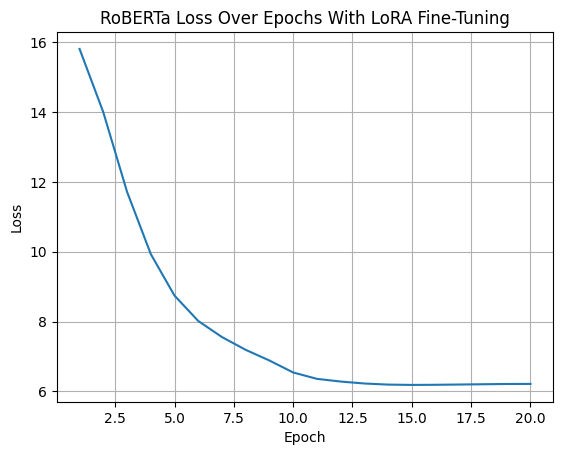

In [ ]:
RoBERTa_loss = [15.806211, 13.992575, 11.716604, 9.934031, 8.743620, 8.017769, 7.556749, 7.190852, 6.885422, 6.542966, 6.360524, 6.283172, 6.227422, 6.195909, 6.186633, 6.190515, 6.198050, 6.205857, 6.213471, 6.215398]
epochs = [i for i in range(1, 21)]

fig, ax = plt.subplots()
ax.plot(epochs, RoBERTa_loss)

ax.set(xlabel='Epoch', ylabel='Loss',
       title='RoBERTa Loss Over Epochs With LoRA Fine-Tuning')
ax.grid()

plt.style.use('default')

plt.show()

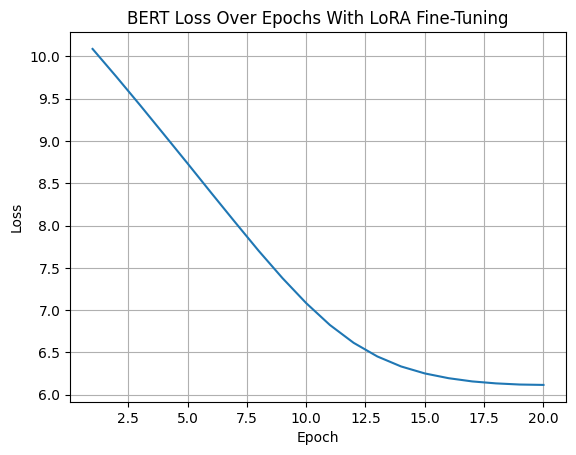

In [ ]:
BERT_loss = [10.088773, 9.760792, 9.424161, 9.080415, 8.735329, 8.386072, 8.040803, 7.7004, 7.3784, 7.0825, 6.82353, 6.612531, 6.451154, 6.33296, 6.250349, 6.194184, 6.155883, 6.132749, 6.119162, 6.114579]
epochs = [i for i in range(1, 21)]

fig, ax = plt.subplots()
ax.plot(epochs, BERT_loss)

ax.set(xlabel='Epoch', ylabel='Loss',
       title='BERT Loss Over Epochs With LoRA Fine-Tuning')
ax.grid()

plt.style.use('default')

plt.show()

In [ ]:
### Distilbert Loss SQuAD
DistilBert = [{'eval_loss': 1.162055253982544, 'eval_runtime': 39.3906, 'eval_samples_per_second': 444.776, 'eval_steps_per_second': 13.912, 'epoch': 1.0},
{'eval_loss': 1.0901474952697754, 'eval_runtime': 39.2756, 'eval_samples_per_second': 446.079, 'eval_steps_per_second': 13.953, 'epoch': 2.0},
{'eval_loss': 1.0958518981933594, 'eval_runtime': 39.296, 'eval_samples_per_second': 445.846, 'eval_steps_per_second': 13.945, 'epoch': 3.0},
{'eval_loss': 1.198603630065918, 'eval_runtime': 39.31, 'eval_samples_per_second': 445.688, 'eval_steps_per_second': 13.94, 'epoch': 4.0},
{'eval_loss': 1.2996889352798462, 'eval_runtime': 39.3238, 'eval_samples_per_second': 445.531, 'eval_steps_per_second': 13.936, 'epoch': 5.0},
{'eval_loss': 1.4528312683105469, 'eval_runtime': 39.2286, 'eval_samples_per_second': 446.613, 'eval_steps_per_second': 13.969, 'epoch': 6.0},
{'eval_loss': 1.5991413593292236, 'eval_runtime': 39.2615, 'eval_samples_per_second': 446.239, 'eval_steps_per_second': 13.958, 'epoch': 7.0},
{'eval_loss': 1.7706589698791504, 'eval_runtime': 39.2804, 'eval_samples_per_second': 446.024, 'eval_steps_per_second': 13.951, 'epoch': 8.0},
{'eval_loss': 1.9096226692199707, 'eval_runtime': 39.2712, 'eval_samples_per_second': 446.128, 'eval_steps_per_second': 13.954, 'epoch': 9.0},
{'eval_loss': 2.068202495574951, 'eval_runtime': 39.2865, 'eval_samples_per_second': 445.954, 'eval_steps_per_second': 13.949, 'epoch': 10.0},
{'eval_loss': 2.166145086288452, 'eval_runtime': 39.317, 'eval_samples_per_second': 445.608, 'eval_steps_per_second': 13.938, 'epoch': 11.0},
{'eval_loss': 2.3128857612609863, 'eval_runtime': 39.2959, 'eval_samples_per_second': 445.848, 'eval_steps_per_second': 13.945, 'epoch': 12.0},
{'eval_loss': 2.452085018157959, 'eval_runtime': 39.4076, 'eval_samples_per_second': 444.584, 'eval_steps_per_second': 13.906, 'epoch': 13.0},
{'eval_loss': 2.658280611038208, 'eval_runtime': 39.2329, 'eval_samples_per_second': 446.564, 'eval_steps_per_second': 13.968, 'epoch': 14.0},
{'eval_loss': 2.730348587036133, 'eval_runtime': 39.3125, 'eval_samples_per_second': 445.66, 'eval_steps_per_second': 13.94, 'epoch': 15.0},
{'eval_loss': 2.8199164867401123, 'eval_runtime': 39.3748, 'eval_samples_per_second': 444.955, 'eval_steps_per_second': 13.918, 'epoch': 16.0},
{'eval_loss': 3.013972520828247, 'eval_runtime': 39.3424, 'eval_samples_per_second': 445.321, 'eval_steps_per_second': 13.929, 'epoch': 17.0},
{'eval_loss': 3.054368019104004, 'eval_runtime': 39.3484, 'eval_samples_per_second': 445.253, 'eval_steps_per_second': 13.927, 'epoch': 18.0},
{'eval_loss': 3.1121437549591064, 'eval_runtime': 39.2104, 'eval_samples_per_second': 446.82, 'eval_steps_per_second': 13.976, 'epoch': 19.0},
{'eval_loss': 3.2179768085479736, 'eval_runtime': 39.3644, 'eval_samples_per_second': 445.072, 'eval_steps_per_second': 13.921, 'epoch': 20.0},
{'eval_loss': 3.4451534748077393, 'eval_runtime': 39.3609, 'eval_samples_per_second': 445.112, 'eval_steps_per_second': 13.922, 'epoch': 21.0},
{'eval_loss': 3.4348464012145996, 'eval_runtime': 39.3363, 'eval_samples_per_second': 445.39, 'eval_steps_per_second': 13.931, 'epoch': 22.0},
{'eval_loss': 3.5040104389190674, 'eval_runtime': 39.297, 'eval_samples_per_second': 445.836, 'eval_steps_per_second': 13.945, 'epoch': 23.0},
{'eval_loss': 3.551069736480713, 'eval_runtime': 39.3368, 'eval_samples_per_second': 445.384, 'eval_steps_per_second': 13.931, 'epoch': 24.0},
{'eval_loss': 3.662884473800659, 'eval_runtime': 39.2917, 'eval_samples_per_second': 445.896, 'eval_steps_per_second': 13.947, 'epoch': 25.0},
{'eval_loss': 3.7183146476745605, 'eval_runtime': 39.2688, 'eval_samples_per_second': 446.156, 'eval_steps_per_second': 13.955, 'epoch': 26.0},
{'eval_loss': 3.730677366256714, 'eval_runtime': 39.2271, 'eval_samples_per_second': 446.631, 'eval_steps_per_second': 13.97, 'epoch': 27.0},
{'eval_loss': 3.6871771812438965, 'eval_runtime': 39.2622, 'eval_samples_per_second': 446.23, 'eval_steps_per_second': 13.957, 'epoch': 28.0},
{'eval_loss': 3.7520525455474854, 'eval_runtime': 39.3136, 'eval_samples_per_second': 445.648, 'eval_steps_per_second': 13.939, 'epoch': 29.0},
{'eval_loss': 3.768725872039795, 'eval_runtime': 39.2716, 'eval_samples_per_second': 446.124, 'eval_steps_per_second': 13.954, 'epoch': 30.0},]

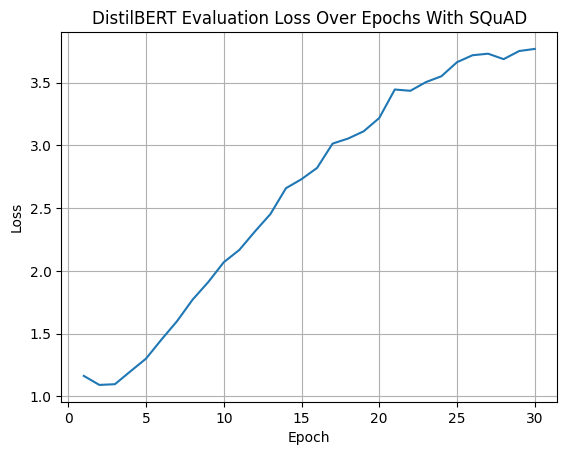

In [ ]:
db_eval_loss = []
for elem in DistilBert:
  db_eval_loss.append(elem['eval_loss'])

epochs = [i for i in range(1, 31)]

fig, ax = plt.subplots()
ax.plot(epochs, db_eval_loss)

ax.set(xlabel='Epoch', ylabel='Loss',
       title='DistilBERT Evaluation Loss Over Epochs With SQuAD')
ax.grid()

plt.style.use('default')

plt.show()

In [ ]:
RoBERTa = [{'eval_loss': 0.8615359663963318, 'eval_runtime': 73.5251, 'eval_samples_per_second': 238.286, 'eval_steps_per_second': 7.453, 'epoch': 1.0},
{'eval_loss': 0.7855591773986816, 'eval_runtime': 73.3063, 'eval_samples_per_second': 238.997, 'eval_steps_per_second': 7.475, 'epoch': 2.0},
{'eval_loss': 0.8508597016334534, 'eval_runtime': 73.1768, 'eval_samples_per_second': 239.42, 'eval_steps_per_second': 7.489, 'epoch': 3.0},
{'eval_loss': 0.900826632976532, 'eval_runtime': 73.2326, 'eval_samples_per_second': 239.238, 'eval_steps_per_second': 7.483, 'epoch': 4.0},
{'eval_loss': 0.9736813306808472, 'eval_runtime': 73.2697, 'eval_samples_per_second': 239.116, 'eval_steps_per_second': 7.479, 'epoch': 5.0},
{'eval_loss': 1.116700530052185, 'eval_runtime': 73.3105, 'eval_samples_per_second': 238.984, 'eval_steps_per_second': 7.475, 'epoch': 6.0},
{'eval_loss': 1.2281275987625122, 'eval_runtime': 73.2743, 'eval_samples_per_second': 239.102, 'eval_steps_per_second': 7.479, 'epoch': 7.0},
{'eval_loss': 1.3222945928573608, 'eval_runtime': 73.2542, 'eval_samples_per_second': 239.167, 'eval_steps_per_second': 7.481, 'epoch': 8.0},
{'eval_loss': 1.4729959964752197, 'eval_runtime': 73.2741, 'eval_samples_per_second': 239.102, 'eval_steps_per_second': 7.479, 'epoch': 9.0},
{'eval_loss': 1.6115294694900513, 'eval_runtime': 73.2397, 'eval_samples_per_second': 239.215, 'eval_steps_per_second': 7.482, 'epoch': 10.0},
{'eval_loss': 1.7478834390640259, 'eval_runtime': 73.2141, 'eval_samples_per_second': 239.298, 'eval_steps_per_second': 7.485, 'epoch': 11.0},
{'eval_loss': 1.8580882549285889, 'eval_runtime': 73.2785, 'eval_samples_per_second': 239.088, 'eval_steps_per_second': 7.478, 'epoch': 12.0},
{'eval_loss': 1.9077914953231812, 'eval_runtime': 73.3556, 'eval_samples_per_second': 238.836, 'eval_steps_per_second': 7.47, 'epoch': 13.0},
{'eval_loss': 2.090178966522217, 'eval_runtime': 73.2223, 'eval_samples_per_second': 239.271, 'eval_steps_per_second': 7.484, 'epoch': 14.0},
{'eval_loss': 2.180607318878174, 'eval_runtime': 73.299, 'eval_samples_per_second': 239.021, 'eval_steps_per_second': 7.476, 'epoch': 15.0},
{'eval_loss': 2.2657220363616943, 'eval_runtime': 73.2021, 'eval_samples_per_second': 239.337, 'eval_steps_per_second': 7.486, 'epoch': 16.0},
{'eval_loss': 2.3958706855773926, 'eval_runtime': 73.2482, 'eval_samples_per_second': 239.187, 'eval_steps_per_second': 7.481, 'epoch': 17.0},
{'eval_loss': 2.6757559776306152, 'eval_runtime': 73.2706, 'eval_samples_per_second': 239.114, 'eval_steps_per_second': 7.479, 'epoch': 18.0},
{'eval_loss': 2.756288766860962, 'eval_runtime': 73.2707, 'eval_samples_per_second': 239.113, 'eval_steps_per_second': 7.479, 'epoch': 19.0},
{'eval_loss': 2.9733307361602783, 'eval_runtime': 73.2889, 'eval_samples_per_second': 239.054, 'eval_steps_per_second': 7.477, 'epoch': 20.0},
{'eval_loss': 2.889509677886963, 'eval_runtime': 73.2511, 'eval_samples_per_second': 239.177, 'eval_steps_per_second': 7.481, 'epoch': 21.0},
{'eval_loss': 2.9583961963653564, 'eval_runtime': 73.3049, 'eval_samples_per_second': 239.002, 'eval_steps_per_second': 7.476, 'epoch': 22.0},
{'eval_loss': 3.1663641929626465, 'eval_runtime': 73.3318, 'eval_samples_per_second': 238.914, 'eval_steps_per_second': 7.473, 'epoch': 23.0},
{'eval_loss': 3.1841418743133545, 'eval_runtime': 73.2599, 'eval_samples_per_second': 239.149, 'eval_steps_per_second': 7.48, 'epoch': 24.0},
{'eval_loss': 3.247512102127075, 'eval_runtime': 73.3049, 'eval_samples_per_second': 239.002, 'eval_steps_per_second': 7.476, 'epoch': 25.0},
{'eval_loss': 3.3434765338897705, 'eval_runtime': 73.2976, 'eval_samples_per_second': 239.025, 'eval_steps_per_second': 7.476, 'epoch': 26.0},
{'eval_loss': 3.373661994934082, 'eval_runtime': 73.2719, 'eval_samples_per_second': 239.109, 'eval_steps_per_second': 7.479, 'epoch': 27.0},
{'eval_loss': 3.374312162399292, 'eval_runtime': 73.3204, 'eval_samples_per_second': 238.951, 'eval_steps_per_second': 7.474, 'epoch': 28.0},
{'eval_loss': 3.3648908138275146, 'eval_runtime': 73.1703, 'eval_samples_per_second': 239.441, 'eval_steps_per_second': 7.489, 'epoch': 29.0},
{'eval_loss': 3.404387950897217, 'eval_runtime': 73.2548, 'eval_samples_per_second': 239.165, 'eval_steps_per_second': 7.481, 'epoch': 30.0}]

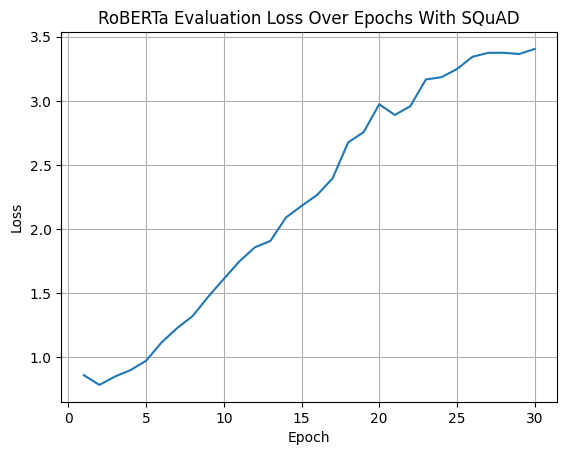

In [ ]:
rba_eval_loss = []
for elem in RoBERTa:
  rba_eval_loss.append(elem['eval_loss'])

epochs = [i for i in range(1, 31)]

fig, ax = plt.subplots()
ax.plot(epochs, rba_eval_loss)

ax.set(xlabel='Epoch', ylabel='Loss',
       title='RoBERTa Evaluation Loss Over Epochs With SQuAD')
ax.grid()

plt.style.use('default')

plt.show()

In [ ]:
BERT = [
    {'eval_loss': 1.0253684520721436, 'eval_runtime': 74.5321, 'eval_samples_per_second': 235.066, 'eval_steps_per_second': 7.353, 'epoch': 1.0},
    {'eval_loss': 0.9865854382514954, 'eval_runtime': 74.1911, 'eval_samples_per_second': 236.147, 'eval_steps_per_second': 7.386, 'epoch': 2.0},
    {'eval_loss': 1.0073989629745483, 'eval_runtime': 74.1966, 'eval_samples_per_second': 236.13, 'eval_steps_per_second': 7.386, 'epoch': 3.0},
    {'eval_loss': 1.1431962251663208, 'eval_runtime': 74.2481, 'eval_samples_per_second': 235.966, 'eval_steps_per_second': 7.381, 'epoch': 4.0},
    {'eval_loss': 1.3095182180404663, 'eval_runtime': 74.3787, 'eval_samples_per_second': 235.551, 'eval_steps_per_second': 7.368, 'epoch': 5.0},
    {'eval_loss': 1.4443864822387695, 'eval_runtime': 74.1141, 'eval_samples_per_second': 236.392, 'eval_steps_per_second': 7.394, 'epoch': 6.0},
    {'eval_loss': 1.664508581161499, 'eval_runtime': 74.2103, 'eval_samples_per_second': 236.086, 'eval_steps_per_second': 7.384, 'epoch': 7.0},
    {'eval_loss': 1.7507418394088745, 'eval_runtime': 74.2193, 'eval_samples_per_second': 236.057, 'eval_steps_per_second': 7.384, 'epoch': 8.0},
    {'eval_loss': 1.8560163974761963, 'eval_runtime': 74.1837, 'eval_samples_per_second': 236.171, 'eval_steps_per_second': 7.387, 'epoch': 9.0},
    {'eval_loss': 2.104992151260376, 'eval_runtime': 74.2283, 'eval_samples_per_second': 236.029, 'eval_steps_per_second': 7.383, 'epoch': 10.0},
    {'eval_loss': 2.1844441890716553, 'eval_runtime': 74.2438, 'eval_samples_per_second': 235.979, 'eval_steps_per_second': 7.381, 'epoch': 11.0},
    {'eval_loss': 2.4247806072235107, 'eval_runtime': 74.1721, 'eval_samples_per_second': 236.208, 'eval_steps_per_second': 7.388, 'epoch': 12.0},
    {'eval_loss': 2.4767208099365234, 'eval_runtime': 74.2463, 'eval_samples_per_second': 235.971, 'eval_steps_per_second': 7.381, 'epoch': 13.0},
    {'eval_loss': 2.743356704711914, 'eval_runtime': 74.248, 'eval_samples_per_second': 235.966, 'eval_steps_per_second': 7.381, 'epoch': 14.0},
    {'eval_loss': 2.8220136165618896, 'eval_runtime': 74.2511, 'eval_samples_per_second': 235.956, 'eval_steps_per_second': 7.38, 'epoch': 15.0},
    {'eval_loss': 2.903488874435425, 'eval_runtime': 74.2703, 'eval_samples_per_second': 235.895, 'eval_steps_per_second': 7.378, 'epoch': 16.0},
    {'eval_loss': 2.9653944969177246, 'eval_runtime': 74.2511, 'eval_samples_per_second': 235.956, 'eval_steps_per_second': 7.38, 'epoch': 17.0},
    {'eval_loss': 3.255969285964966, 'eval_runtime': 74.2884, 'eval_samples_per_second': 235.838, 'eval_steps_per_second': 7.377, 'epoch': 18.0},
    {'eval_loss': 3.207602024078369, 'eval_runtime': 74.2434, 'eval_samples_per_second': 235.981, 'eval_steps_per_second': 7.381, 'epoch': 19.0},
    {'eval_loss': 3.3967819213867188, 'eval_runtime': 74.3061, 'eval_samples_per_second': 235.781, 'eval_steps_per_second': 7.375, 'epoch': 20.0},
    {'eval_loss': 3.3914620876312256, 'eval_runtime': 74.3544, 'eval_samples_per_second': 235.628, 'eval_steps_per_second': 7.37, 'epoch': 21.0},
    {'eval_loss': 3.708918571472168, 'eval_runtime': 74.255, 'eval_samples_per_second': 235.944, 'eval_steps_per_second': 7.38, 'epoch': 22.0},
    {'eval_loss': 3.6687815189361572, 'eval_runtime': 74.3049, 'eval_samples_per_second': 235.785, 'eval_steps_per_second': 7.375, 'epoch': 23.0},
    {'eval_loss': 3.688912868499756, 'eval_runtime': 74.3412, 'eval_samples_per_second': 235.67, 'eval_steps_per_second': 7.371, 'epoch': 24.0},
    {'eval_loss': 3.817662000656128, 'eval_runtime': 74.2464, 'eval_samples_per_second': 235.971, 'eval_steps_per_second': 7.381, 'epoch': 25.0},
    {'eval_loss': 3.7981185913085938, 'eval_runtime': 74.2466, 'eval_samples_per_second': 235.97, 'eval_steps_per_second': 7.381, 'epoch': 26.0},
    {'eval_loss': 3.862046003341675, 'eval_runtime': 74.3382, 'eval_samples_per_second': 235.68, 'eval_steps_per_second': 7.372, 'epoch': 27.0},
    {'eval_loss': 3.806727170944214, 'eval_runtime': 74.3202, 'eval_samples_per_second': 235.737, 'eval_steps_per_second': 7.374, 'epoch': 28.0},
    {'eval_loss': 3.881267786026001, 'eval_runtime': 74.248, 'eval_samples_per_second': 235.966, 'eval_steps_per_second': 7.381, 'epoch': 29.0},
    {'eval_loss': 3.8511414527893066, 'eval_runtime': 74.3308, 'eval_samples_per_second': 235.703, 'eval_steps_per_second': 7.372, 'epoch': 30.0}
]

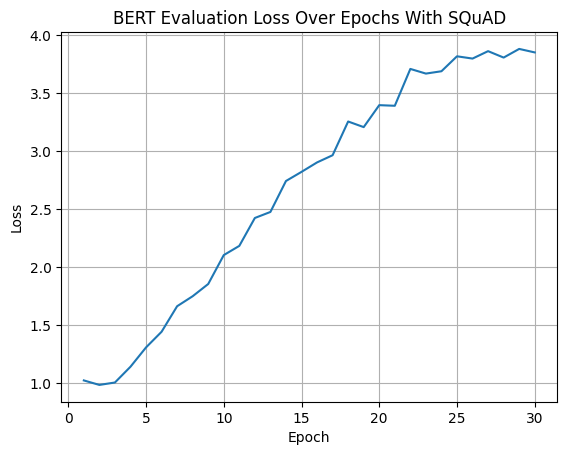

In [ ]:
b_eval_loss = []
for elem in BERT:
  b_eval_loss.append(elem['eval_loss'])

epochs = [i for i in range(1, 31)]

fig, ax = plt.subplots()
ax.plot(epochs, b_eval_loss)

ax.set(xlabel='Epoch', ylabel='Loss',
       title='BERT Evaluation Loss Over Epochs With SQuAD')
ax.grid()

plt.style.use('default')

plt.show()